In [179]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
from statistics import median
from keras.utils import plot_model #интересные возможности Keras
from keras.models import load_model #для сохранения/загрузки модели
from tensorflow.keras.callbacks import EarlyStopping

In [110]:
def read_file(df):
    df = pd.read_csv('Vibro.csv',sep = ';')
    return df

def str_in_time(df):#перевод строки в дату
    for i in range(0, 8000):
        a = datetime.strptime(df['Tag_Date'][i],"%d.%m.%Y %H:%M:%S")
        df.loc[i,'Tag_Date'] = a#.timestamp()
        #print(i,end=' ')
    return df

def check_limit(value, limit): #проверяем есть ли превышения в конкретный момент времени
    if(value >= limit):
        return 1
    else:
        return 0
    
def sum_cov_in_time (event,limit): #сумма превышений на интервале 
    sum_ = 0
    #print(event[1],end=' ')
    for i in range(0, len(event)):
        sum_ = sum_ + check_limit(event[i],limit)
    return sum_

def structrure_data(df,struct_data_for_train, dt, count_vibration, limit_cov):#размеч.данные,0/1нет/есть кав.   
    for i in range(0,len(df)-dt):
        #struct_data_for_train.loc[i,'Tag_Date'] = df['Tag_Date'][i]
        
        for j in range(0, dt):
            struct_data_for_train.loc[i, j+1]=df['Tag_Value'][j+i]
            
        if(sum_cov_in_time(struct_data_for_train.iloc[i].values,limit_cov) > count_vibration):
            struct_data_for_train.loc[i,'Cov'] = 1
        else:
            struct_data_for_train.loc[i,'Cov'] = 0
            
    return struct_data_for_train

def rele(df):
    for i in range (0, len(df)):
        if(df[i]>0.5):
            df[i] = 1
        else:
            df[i] = 0
    return df

def plot_in(df): #график входных данных, зависимость времени от показания вибрации
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size':22})
    plt.plot(df['Tag_Date'], df['Tag_Value'])
    plt.grid()
    plt.show()
    return 0

def plot_in_(df): #график входных данных, зависимость времени от показания вибрации
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size':22})
    plt.plot(df['Tag_Date'], df['1'])
    plt.grid()
    plt.show()
    return 0

def error(df1, df2):
    er = 0
    for i in range(0, len(df1)):
        if df1[i]!=df2[i]:
            er = er+1
    print(er,end=' ')
    print(len(df1))
    return er/len(df1)

In [3]:
def str_in_time_(df, max_):#перевод строки в дату
    for i in range(0, max_):
        a = datetime.strptime(df['Tag_Date'][i],"%d.%m.%Y %H:%M:%S")
        df.loc[i,'Tag_Date'] = a#.timestamp()
        #print(i,end=' ')
    return df
def str_in_time_last(df, max_):#перевод строки в дату
    for i in range(0, max_):
        a = datetime.strptime(df['Tag_Date'][i],"%Y-%m-%d %H:%M:%S")
        df.loc[i,'Tag_Date'] = a#.timestamp()
        #print(i,end=' ')
    return df

In [4]:
df = pd.DataFrame() #показание датчика вибрации
df_labeled_training_data = pd.DataFrame() #строка-показания за временной интервал, 1/0 Есть/Нет кавитации
df = read_file(df) #читаем показания вибрации с файла
#df_labeled_training_data = structrure_data(df[0:4000], df_labeled_training_data, 30, 5, 5) #размечаем данные

In [5]:
df = str_in_time_(df,8000)#перевод даты в формат datatime
#df_labeled_training_data['Tag_Date'] = df['Tag_Date']
#df_labeled_training_data.to_csv('df_0_4000_time.csv',index=False)
df_labeled_training_data = pd.read_csv('df_0_4000_time.csv',sep = ',')

In [6]:
#Создание обучающий и тестовой выборки
X_test = np.array(df_labeled_training_data[2000:4000].drop(columns = ['Cov','Tag_Date']).values)
Y_test_re = np.array(df_labeled_training_data['Cov'][2000:4000])

X_train = np.array(df_labeled_training_data[0:2000].drop(columns = ['Cov','Tag_Date']).values)
Y_train = np.array(df_labeled_training_data['Cov'][0:2000].values)

In [181]:
early_stopping_callback = EarlyStopping(monitor='val_acc', patience=2)

In [182]:
# Создаём модель!
model_V = Sequential()
# Добавляем первый слой Dense, первое число 3 - это количество нейронов, 
# input_dim - количество фич на вход
# activation -  функция активации, полулинейная функция max(x, 0) 
# именно полулинейные функции позволяют получать нелинейные результаты с минимальными затратами
model_V.add(Dense(7, input_dim = 30, activation='sigmoid'))
# добавляем второй слой с 1 нейронами

model_V.add(Dense(1, activation='relu'))
# на выходе при бинарной классификации, функцию активации чаще всего используют sigmoid , реже softmax
# Компилирование модели. binary_crossentropy - опять же не случайно, а т.к. у нас два класса.
# Метрика accuracy используется практически для всех задач классификации
model_V.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
# Наконец дошли до обучения модели, X и Y - понятно, 
# epoch - максимальное количество эпох до остановки
# batInput 0 is incompatible with layer flatten_1: expected min_ndim=3, found ndim=2ch_size - сколько объектов будет загружаться за итерацию
model_V.fit(X_train, Y_train, epochs=5, batch_size=1,  verbose=2,callbacks=[early_stopping_callback])
# Предсказание
#predictions = model_V.predict(X_train)

Epoch 1/5
 - 12s - loss: 0.3385 - acc: 0.9415
Epoch 2/5
 - 9s - loss: 0.1081 - acc: 0.9570
Epoch 3/5
 - 8s - loss: 0.0814 - acc: 0.9600
Epoch 4/5
 - 8s - loss: 0.0651 - acc: 0.9630
Epoch 5/5
 - 9s - loss: 0.0610 - acc: 0.9750


In [64]:
model_V.save('model_vibro.h5')  # creates a HDF5 file 'my_model.h5'
del model_V  # deletes the existing model

# returns a compiled model
# identical to the previous one
model_V = load_model('model_vibro.h5')

In [178]:
#plot_model(model_V, to_file='model.png', show_shapes=True) #pydot не поставился?

In [50]:
Y_test_pr = model_V.predict(X_test)#предсказанные значения 
#Y_test_pr = rele(Y_test_pr) #пропускаем через реле, округление

In [51]:
Y_test_pr[11]

array([1.], dtype=float32)

In [93]:
score = model_V.evaluate(X_test, Y_test_re, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.20649539355931792
Test accuracy: 0.9370558375634518


In [52]:
#for i in range(0,len(Y_test_pr)):
#    if(Y_test_re[i]!=0):
#        print(Y_test_re[i], ' ', i)

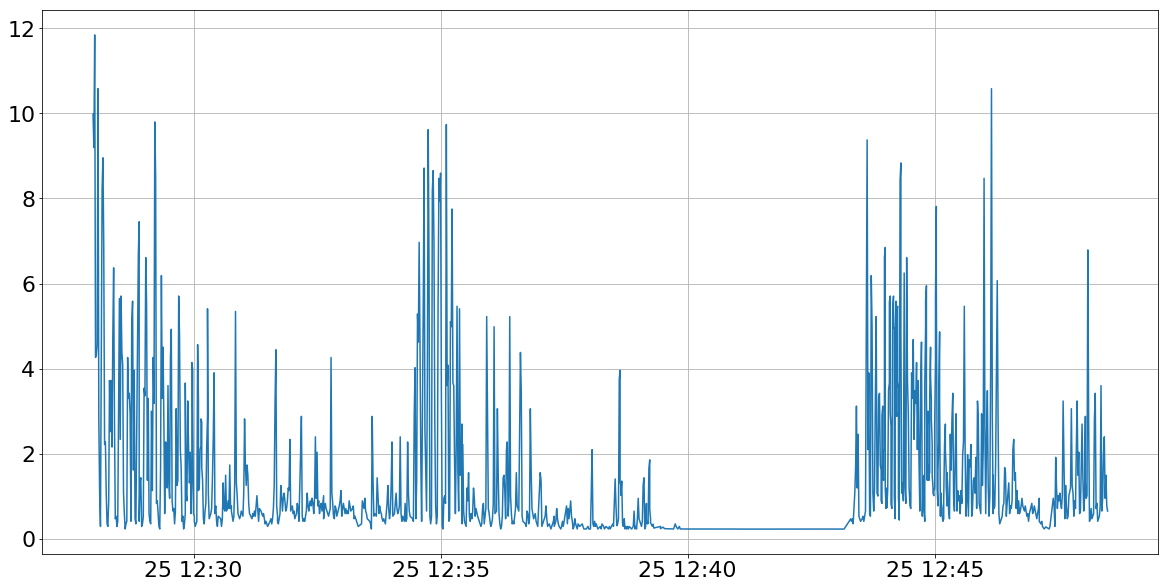

0

In [53]:
plot_in(df[2000:3000])

124 1970
0.06294416243654823


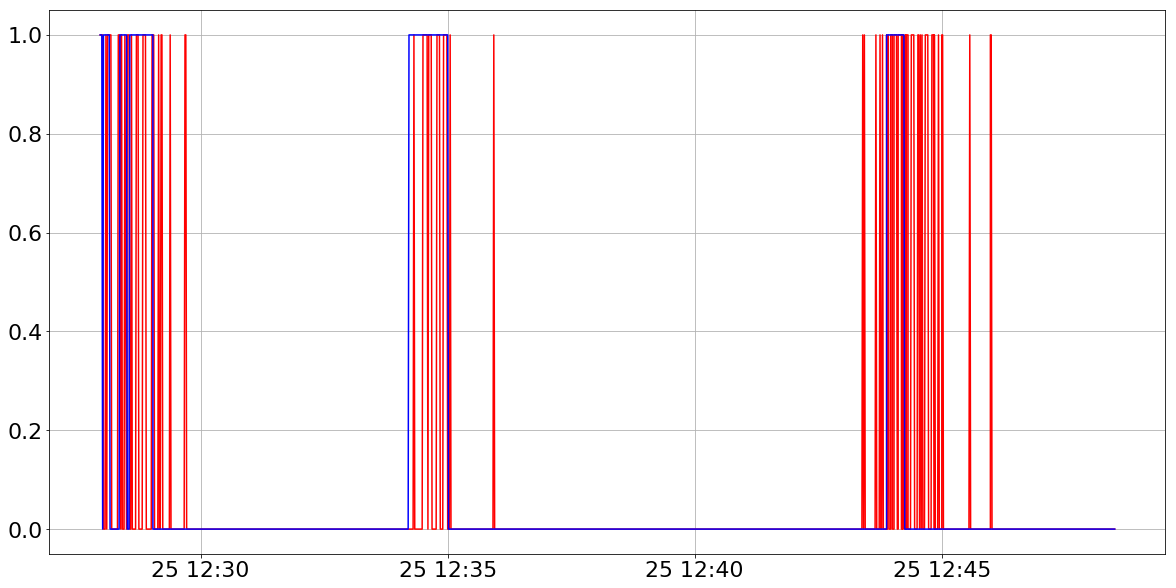

In [54]:
print(error(Y_test_pr, Y_test_re))

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':22})

plt.plot(df['Tag_Date'][2000:3000], Y_test_pr[0:1000], 'red')
plt.plot(df['Tag_Date'][2000:3000], Y_test_re[0:1000],'blue')

plt.grid()
plt.show()

In [48]:
def create_df_on_plot(df,dt): #редактирую для построение графика с прямыми линиями
    res = [0]*len(df)
    dt = dt*30
    for i in range (0,len(df)-dt):
        print(df[i],end =' ')
        if(df[i]==1):
            if(df[i+1]==0):
                for k in range(i, i+dt):
                    res[k]=1
                i = i + dt
            else:
                i = i + 1
        else:
            res[i] = 0
    return np.array(res)

In [ ]:
k = create_df_on_plot(Y_test_pr,30)

In [ ]:
print(error(Y_test_pr, Y_test_re))
Y_= Y_test_re*6
k_ = k * 6
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':22})
plt.plot(df['Tag_Date'][2000:3000], df['Tag_Value'][2000:3000])
plt.plot(df['Tag_Date'][2000:3000], k_[0:1000], 'red')
plt.plot(df['Tag_Date'][2000:3000], Y_[0:1000],'green')


plt.grid()
plt.show()

In [ ]:
predect_Tag_Date = pd.DataFrame()
predect_Tag_Date['Tag_Date'] = df['Tag_Date'][2000:3970].copy(deep = True)

predect_Tag_Date['Cov'] = Y_test_pr

In [125]:
def create_df_on_plot_time(df,dt):
    res = [0]*len(df)
    dt = timedelta(minutes = dt)
    for i in range (2000,3970):
        if(df['Cov'][i]==1):
            #print(i)
            for j in range (i,3970):
                res[j-2000] = 1
                #print(res[j-2000])
                if(df['Tag_Date'][j]-df['Tag_Date'][i] >= dt):
                    i = j-1
                    break
                    print(i)
    
    return np.array(res)

In [ ]:
pre = create_df_on_plot_time(predect_Tag_Date,0.5)

In [ ]:
print(error(Y_test_pr, Y_test_re))
Y_= Y_test_re*6
k_ = pre *6
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':22})
plt.plot(df['Tag_Date'][2000:3000], df['Tag_Value'][2000:3000])
plt.plot(df['Tag_Date'][2000:3000], k_[0:1000],'red',linewidth = 3)
plt.plot(df['Tag_Date'][2000:3000], Y_[0:1000],'green',linewidth = 3)

plt.legend ( ("Показание виброскорости","Промежуток кавитации (нейронная сеть)", "Промежуток кавитации(алгоритм)") )
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':22})
plt.plot(df['Tag_Value'][0:20000],df.index[0:20000],'ro')
plt.show()

# Формирование обучающей и тестовой выборки

In [ ]:
# Тружусь над добавлением данных по PRESS_IN. проблема - нормальзация данных! (Фомин)
df_normalize = pd.DataFrame()
df_normalize = df_labeled_training_data.copy(deep = True)
df_normalize['Tag_Date'] =df['Tag_Date'][0:3970].copy(deep = True)

press = pd.DataFrame()#не нормализованные данные с датчика давления на входе
press = pd.read_csv('PressIn.csv',sep = ';')
press = str_in_time_(press,8000)
press = press.dropna()#удаление None


In [ ]:
def create_test_dates(df_normalize, df, press, dt):
    buf = 0
    
    for i in range (0, len(df_normalize)):
        data_array = []
        for j in range(buf, len(press)):
            if(press['Tag_Date'][j] >= df['Tag_Date'][i]):
                data_array.append(press['Tag_Value'][j])
            if(press['Tag_Date'][j] > df['Tag_Date'][i+dt]):
                if(len(data_array)==0):
                    print(i,end = ' ')
                print(data_array)
                df_normalize.loc[i, 'Min_Press_In'] = min(data_array)
                df_normalize.loc[i, 'Max_Press_In'] = max(data_array)
                df_normalize.loc[i, 'Median'] = median(data_array)
                break
            buf = j
        
    return df_normalize

In [ ]:
press.index = np.arange(len(press))
#df_all_normalize = pd.DataFrame()
#df_all_normalize = create_test_dates(df_normalize,df,press,30)

In [67]:
#df_all_normalize.to_csv('Date_for_tast_uncorrectCov.csv',index= False)
df_all_normalize = pd.read_csv("Date_for_tast_uncorrectCov.csv")
df_all_normalize = str_in_time_last(df_all_normalize,len(df_all_normalize))

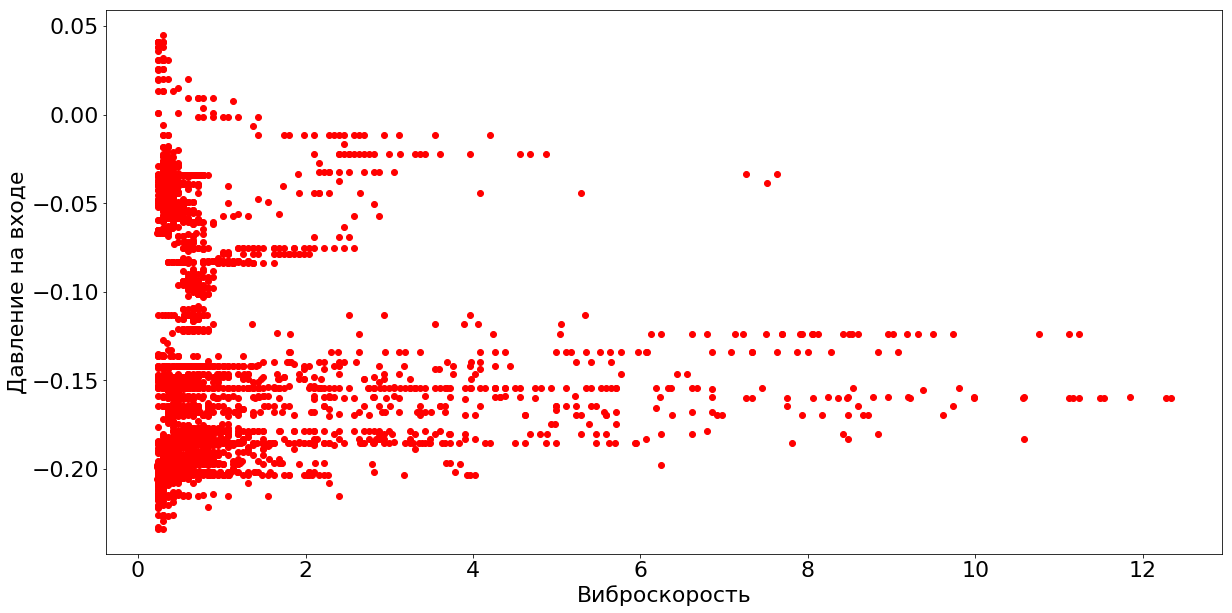

In [68]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':22})
plt.plot(df_all_normalize['1'],df_all_normalize['Median'],'ro')
#plt.grid()
plt.xlabel('Виброскорость')
plt.ylabel('Давление на входе')
#plt.title('Распределение ')
plt.show()

In [ ]:
df_all_normalize#.loc[df_all_normalize['Cov']==1]

In [69]:
def correct_with_press(df_all_normalize,rule):
    for i in range(0, len(df_all_normalize)):
        if(df_all_normalize['Median'][i] < rule):
            df_all_normalize.loc[i,'Cov'] = 1
    return df_all_normalize

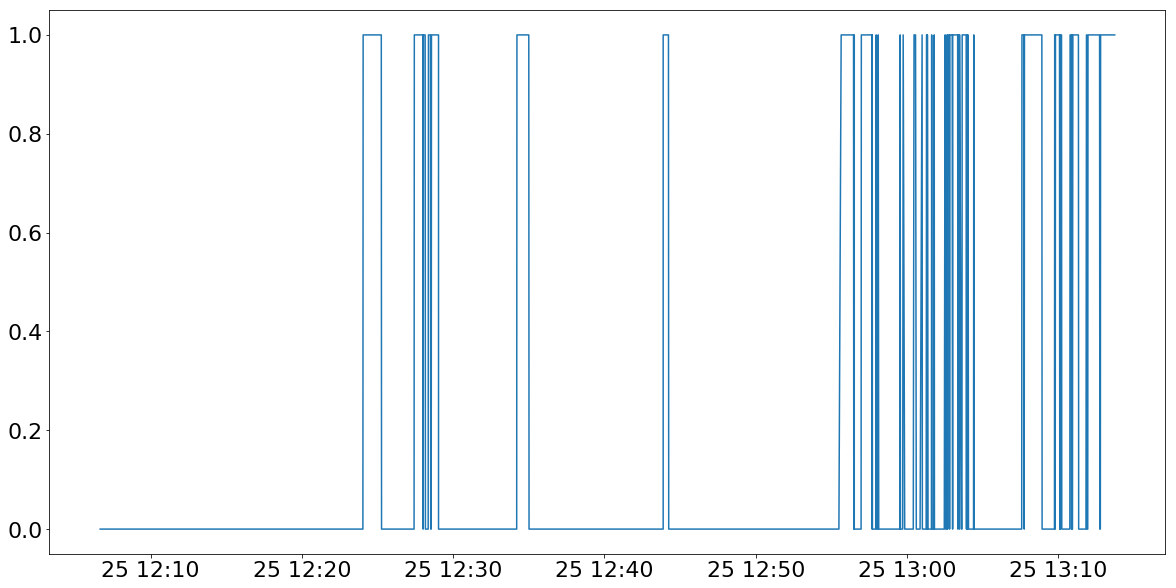

In [78]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':22})
plt.plot(df_all_normalize_['Tag_Date'][1000:len(df_all_normalize_)], df_all_normalize_['Cov'][1000:len(df_all_normalize_)])
plt.show()

# Вторая часть. Обучение нейройнной сети на данных Vibro и Press

In [183]:
#Создание обучающий и тестовой выборки
X_test_PV = np.array(df_all_normalize_[2000:3970].drop(columns = ['Cov','Tag_Date']).values)
Y_test_re_PV = np.array(df_all_normalize_['Cov'][2000:3970])

X_train_PV = np.array(df_all_normalize_[0:2000].drop(columns = ['Cov','Tag_Date']).values)
Y_train_PV = np.array(df_all_normalize_['Cov'][0:2000].values)

In [184]:
early_stopping_callback = EarlyStopping(monitor='val_acc', patience=2)#защищаем от переобучения

In [185]:
# Создаём модель!
model_PV = Sequential()
# Добавляем первый слой Dense, первое число 3 - это количество нейронов, 
# input_dim - количество фич на вход
# activation -  функция активации, полулинейная функция max(x, 0) 
# именно полулинейные функции позволяют получать нелинейные результаты с минимальными затратами
model_PV.add(Dense(7, input_dim = 33, activation='sigmoid'))
# добавляем второй слой с 1 нейронами

model_PV.add(Dense(1, activation='sigmoid'))
# на выходе при бинарной классификации, функцию активации чаще всего используют sigmoid , реже softmax
# Компилирование модели. binary_crossentropy - опять же не случайно, а т.к. у нас два класса.
# Метрика accuracy используется практически для всех задач классификации
model_PV.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
# Наконец дошли до обучения модели, X и Y - понятно, 
# epoch - максимальное количество эпох до остановки
# batInput 0 is incompatible with layer flatten_1: expected min_ndim=3, found ndim=2ch_size - сколько объектов будет загружаться за итерацию
model_PV.fit(X_train_PV, Y_train_PV, epochs=30, batch_size=1,  verbose=2)
# Предсказание
#predictions = model_V.predict(X_train)

Epoch 1/30
 - 12s - loss: 0.2841 - acc: 0.9145
Epoch 2/30
 - 7s - loss: 0.1843 - acc: 0.9260
Epoch 3/30
 - 8s - loss: 0.1269 - acc: 0.9260
Epoch 4/30
 - 8s - loss: 0.0858 - acc: 0.9535
Epoch 5/30
 - 8s - loss: 0.0638 - acc: 0.9850
Epoch 6/30
 - 10s - loss: 0.0510 - acc: 0.9880
Epoch 7/30
 - 9s - loss: 0.0421 - acc: 0.9865
Epoch 8/30
 - 10s - loss: 0.0376 - acc: 0.9865
Epoch 9/30
 - 10s - loss: 0.0336 - acc: 0.9880
Epoch 10/30
 - 10s - loss: 0.0303 - acc: 0.9900
Epoch 11/30
 - 9s - loss: 0.0275 - acc: 0.9900
Epoch 12/30
 - 10s - loss: 0.0261 - acc: 0.9915
Epoch 13/30
 - 10s - loss: 0.0225 - acc: 0.9920
Epoch 14/30
 - 10s - loss: 0.0229 - acc: 0.9925
Epoch 15/30
 - 9s - loss: 0.0213 - acc: 0.9930
Epoch 16/30
 - 9s - loss: 0.0181 - acc: 0.9930
Epoch 17/30
 - 9s - loss: 0.0189 - acc: 0.9945
Epoch 18/30
 - 9s - loss: 0.0164 - acc: 0.9940
Epoch 19/30
 - 9s - loss: 0.0163 - acc: 0.9950
Epoch 20/30
 - 9s - loss: 0.0147 - acc: 0.9960
Epoch 21/30
 - 9s - loss: 0.0147 - acc: 0.9955
Epoch 22/30
 -

In [188]:
Y_test_pr_PV = model_PV.predict(X_test_PV)#предсказанные значения 

In [187]:
Y_test_pr_PV = rele(Y_test_pr_PV)

In [189]:
score = model_PV.evaluate(X_test_PV, Y_test_re_PV, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.4684793442843167
Test accuracy: 0.8106598984771574


In [190]:
len(df_all_normalize)

3970

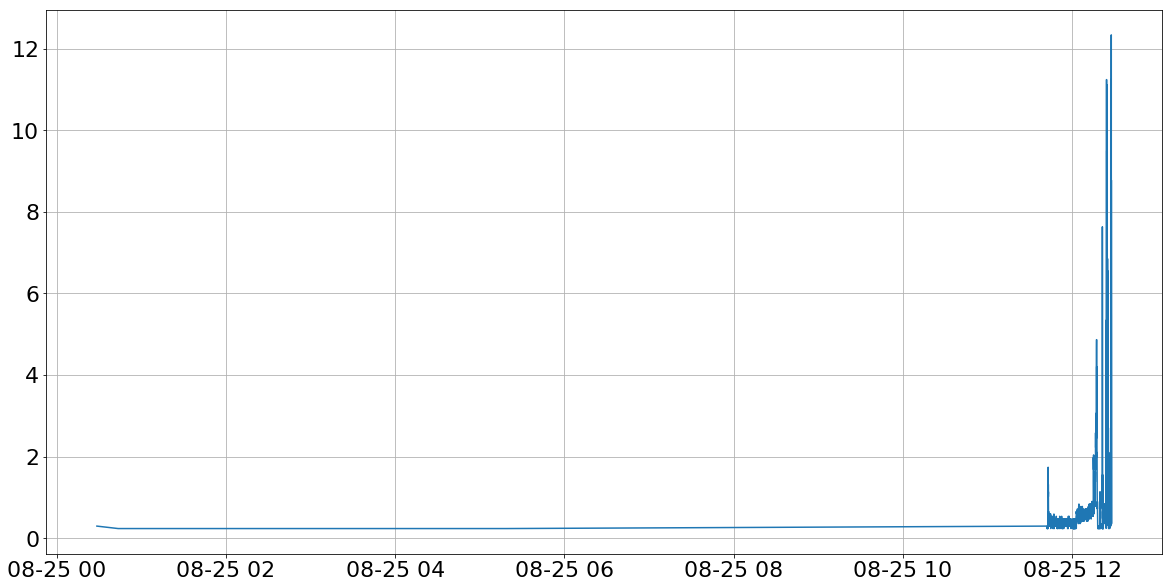

0

In [191]:
plot_in_(df_all_normalize[0:2000])

1970 1970
1.0


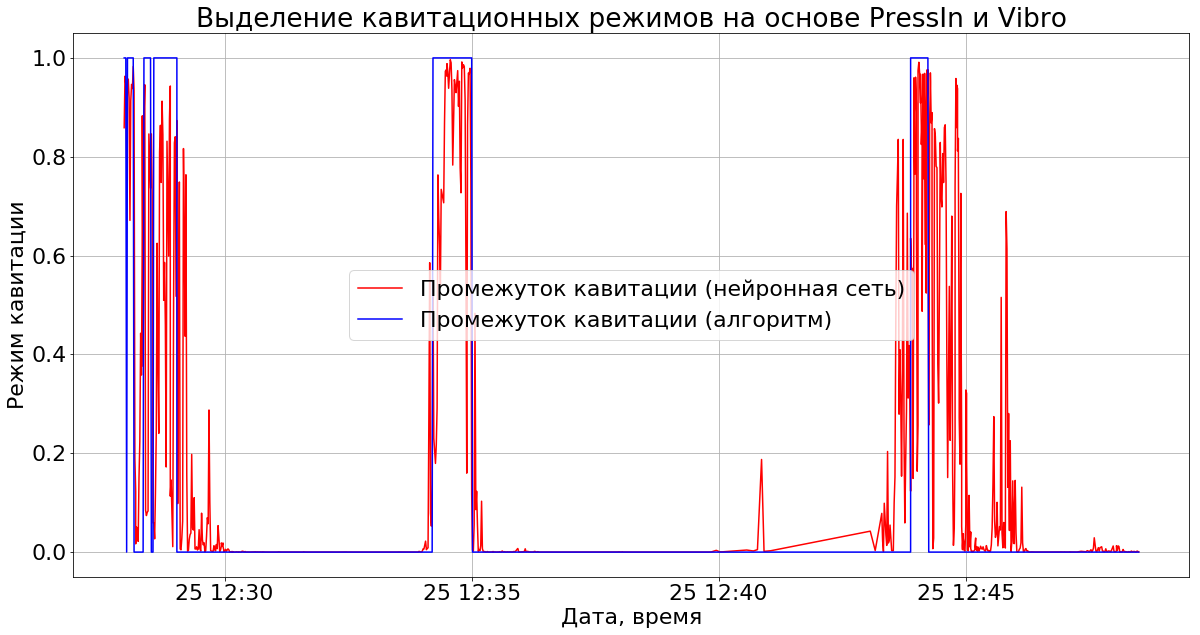

In [192]:
print(error(Y_test_pr_PV, Y_test_re_PV))

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':22})

plt.plot(df_all_normalize['Tag_Date'][2000:3000], Y_test_pr_PV[0:1000], 'red')
plt.plot(df_all_normalize['Tag_Date'][2000:3000], Y_test_re_PV[0:1000],'blue')

plt.xlabel('Дата, время')
plt.ylabel('Режим кавитации')
plt.title('Выделение кавитационных режимов на основе PressIn и Vibro')
plt.legend ( ("Промежуток кавитации (нейронная сеть)", "Промежуток кавитации (алгоритм)") )
plt.grid()
plt.show()

In [196]:
df_normalize_PV = pd.DataFrame()

df_normalize_PV['Tag_Date'] =df['Tag_Date'][2000:3970].copy(deep = True)
df_normalize_PV['Cov'] = Y_test_pr_PV

In [199]:
pre_PV = df_normalize_PV['Cov']#create_df_on_plot_time(df_normalize_PV,0.5)

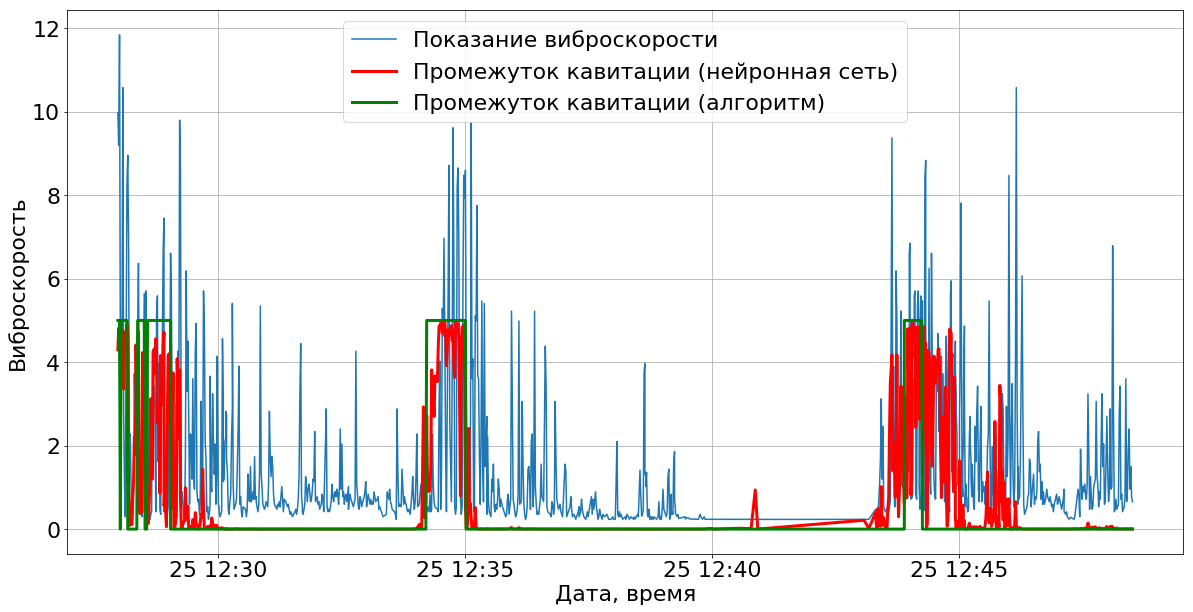

In [200]:
Y_PV= Y_test_re_PV*5
k_PV = pre_PV *5
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':22})
plt.plot(df_all_normalize['Tag_Date'][2000:3000], df_all_normalize['1'][2000:3000])
plt.plot(df_all_normalize['Tag_Date'][2000:3000], k_PV[0:1000],'red',linewidth = 3)
plt.plot(df_all_normalize['Tag_Date'][2000:3000], Y_PV[0:1000],'green',linewidth = 3)

plt.xlabel('Дата, время')
plt.ylabel('Виброскорость')
plt.legend ( ("Показание виброскорости","Промежуток кавитации (нейронная сеть)", "Промежуток кавитации (алгоритм)") )
plt.grid()
plt.show()

In [176]:
model_PV.save('model_vibro_PV.h5')  # creates a HDF5 file 'my_model.h5'
del model_PV  # deletes the existing model

# returns a compiled model
# identical to the previous one
model_PV = load_model('model_vibro_PV.h5')